In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import librosa
import csv
import os

In [ ]:
filesound = "/content/gdrive/My Drive/Sem1 - Speech processing/project/data/recordings/test/0_jackson_49.wav"
y, sr = librosa.load(filesound, mono=True, duration=30)
print(y)
import IPython.display as ipd
ipd.Audio(filesound)

[-0.00898135 -0.01068527 -0.01089107 ... -0.01080694 -0.00801174
  0.        ]


In [ ]:

# Defines the names of the CSV files
TRAIN_CSV_FILE = "/content/gdrive/My Drive/Sem1 - Speech processing/project/src/train_t.csv"
TEST_CSV_FILE = "/content/gdrive/My Drive/Sem1 - Speech processing/project/src/test_t.csv"


In [ ]:
CREATE_CSV_FILES = True

def extractWavFeatures(soundFilesFolder, csvFileName):
    print("The features of the files in the folder "+soundFilesFolder+" will be saved to "+csvFileName)
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    
    for i in range(1, 20):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    print('CSV Header: ', header)
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    genres = '1 2 3 4 5 6 7 8 9 0'.split()
    for filename in os.listdir(soundFilesFolder):
        number = f'{soundFilesFolder}/{filename}'
        y, sr = librosa.load(number, mono=True, duration=30)
        # remove leading and trailing silence
        y, index = librosa.effects.trim(y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
         
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        writer.writerow(to_append.split())
    file.close()
    print("End of extractWavFeatures")


if (CREATE_CSV_FILES == True):
    extractWavFeatures("/content/gdrive/My Drive/Sem1 - Speech processing/project/data/recordings/train_t", TRAIN_CSV_FILE)
    extractWavFeatures("/content/gdrive/My Drive/Sem1 - Speech processing/project/data/recordings/test_t", TEST_CSV_FILE)
    print("CSV files are created")
else:
    print("CSV files creation is skipped")

The features of the files in the folder /content/gdrive/My Drive/Sem1 - Speech processing/project/data/recordings/train_t will be saved to /content/gdrive/My Drive/Sem1 - Speech processing/project/src/train_t.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'label']


KeyboardInterrupt: ignored

In [ ]:
#Reading a dataset and convert file name to corresbonding umnber

import pandas as pd
import csv
from sklearn import preprocessing

def preProcessData(csvFileName):
    print(csvFileName+ " will be preprocessed")
    data = pd.read_csv(csvFileName)
    # we have five speakers: 
    # 0: Carole
    # 1: Jackson
    # 2: Nicolas 
    # 3: Theo

    filenameArray = data['filename'] 
    speakerArray = []; digitArray = [];
    #print(filenameArray)
    for i in range(len(filenameArray)):
        speaker = filenameArray[i][2]
        if speaker == "a":
            speaker = 0
        elif speaker == "c":
            speaker = 1
        elif speaker == "j":
            speaker = 2
        elif speaker == "n":
            speaker = 3
        elif speaker == "t":
            speaker = 4
        else: 
            speaker = 5
        speakerArray.append(speaker)
        digitArray.append(int(filenameArray[i][0]))
    data['digit'] = digitArray
    data['number'] = speakerArray
    #Dropping unnecessary columns
    data = data.drop(['filename'],axis=1)
    data = data.drop(['label'],axis=1)
    data = data.drop(['chroma_stft'],axis=1)
    data.shape

    #print("Preprocessing is finished")
    #print(data.head())
    return data

trainData = preProcessData(TRAIN_CSV_FILE)
testData = preProcessData(TEST_CSV_FILE)
#print(testData['number'])


/content/gdrive/My Drive/Sem1 - Speech processing/project/src/train_final.csv will be preprocessed
/content/gdrive/My Drive/Sem1 - Speech processing/project/src/test_final.csv will be preprocessed


In [ ]:
# Splitting the dataset into training, validation and testing dataset
from sklearn.model_selection import train_test_split
X = np.array(trainData.iloc[:, :-2], dtype = float)
y1 = trainData.iloc[:, -1] #number
y2 = trainData.iloc[:, -2] #digit

X_train, X_val, y1_train, y1_val = train_test_split(X, y1, test_size=0.2, random_state=42)
X_train, X_val, y2_train, y2_val = train_test_split(X, y2, test_size=0.2, random_state=42)

X_test = np.array(testData.iloc[:, :-2], dtype = float)
y1_test =  testData.iloc[:, -1] #number
y2_test =  testData.iloc[:, -2] #digit

print("Y from training data:", y1_train.shape)
print("Y from validation data:", y2_val.shape)
print("Y1 from test data:", y1_test.shape)
print("Y2 from test data:", y2_test.shape)

Y from training data: (432,)
Y from validation data: (108,)
Y1 from test data: (50,)
Y2 from test data: (50,)


In [ ]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )
X_test = scaler.transform( X_test )
X_t = scaler.fit_transform(X)
print("X from training data", X_train.shape)
print("X from validation data", X_val.shape)
print("X from test data", X_test.shape)

X from training data (432, 24)
X from validation data (108, 24)
X from test data (50, 24)


In [ ]:
#using euclidean distance
from scipy.spatial import distance

eudist = []; y_predicted = []; indexout = []
dict_y1_train = y1.to_dict()  # speaker
dict_y2_train = y2.to_dict()  #digit

for i in range(len(X_test)):
  for j in range(len(X_t)): #len(X_t) #excluding val X
    eudist.append( distance.euclidean(X_test[i], X_t[j] ) )
  indexv = eudist.index(min(eudist))
  eudist = []
  y_predicted.append( [ dict_y1_train[indexv], dict_y2_train[indexv] ] )

nCorrect_speaker = 0;  nCorrect_digit  = 0;  
#print("predicted, actual, match") 
for i in range(50):
  print("speaker", y_predicted[i][0], y1_test.iloc[i], y_predicted[i][0] == y1_test.iloc[i], "digit", y_predicted[i][1], y2_test.iloc[i], y_predicted[i][1] == y2_test.iloc[i] )
  if y_predicted[i][0] == y1_test.iloc[i]:
        nCorrect_speaker += 1
  if y_predicted[i][1] == y2_test.iloc[i]:
        nCorrect_digit += 1
    
percentageCorrect_speaker = (nCorrect_speaker/50)*100
print('Accuracy of speaker with MFCC-GMM is ', percentageCorrect_speaker, '%')

percentageCorrect_digit = (nCorrect_digit/50)*100
print('Accuracy of digit with MFCC-GMM is ', percentageCorrect_digit, '%')


Accuracy of speaker with MFCC-GMM is  100.0 %
Accuracy of digit with MFCC-GMM is  84.0 %


In [ ]:
#Creating a Model
from keras import models
from keras import layers
import keras

# model 1
model1 = models.Sequential()
model1.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(5, activation='softmax'))
# Learning Process of a model
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# model 2
model2 = models.Sequential()
model2.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(20, activation='softmax'))
# Learning Process of a model
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

print("model 1 for predicting speaker")
#Train with early stopping to avoid overfitting
history1 = model1.fit(X_train,
                    y1_train,
                    validation_data=(X_val, y1_val), 
                    epochs= 40,
                    batch_size= 32)
                    #callbacks=[es])

print("model 2 for predicting digit")
history2 = model2.fit(X_train,y2_train,
                     validation_data=(X_val, y2_val),
                     epochs= 200,
                     batch_size= 32)
                    #callbacks=[es])


model 1 for predicting speaker
Epoch 1/40
14/14 [==============================] - 1s 18ms/step - loss: 1.5108 - accuracy: 0.3588 - val_loss: 1.0124 - val_accuracy: 0.8704
Epoch 2/40
14/14 [==============================] - 0s 6ms/step - loss: 1.0087 - accuracy: 0.6343 - val_loss: 0.5998 - val_accuracy: 0.8981
Epoch 3/40
14/14 [==============================] - 0s 5ms/step - loss: 0.6437 - accuracy: 0.7986 - val_loss: 0.3247 - val_accuracy: 0.9630
Epoch 4/40
14/14 [==============================] - 0s 5ms/step - loss: 0.4302 - accuracy: 0.8843 - val_loss: 0.1763 - val_accuracy: 0.9907
Epoch 5/40
14/14 [==============================] - 0s 6ms/step - loss: 0.3120 - accuracy: 0.8958 - val_loss: 0.0984 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 5ms/step - loss: 0.2209 - accuracy: 0.9398 - val_loss: 0.0524 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 6ms/step - loss: 0.1615 - accuracy: 0.9491 - val_loss: 0.0282 - val_accur

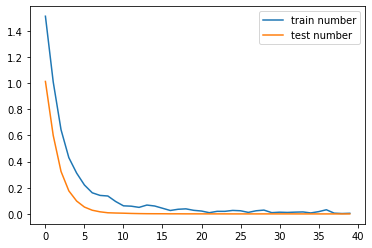

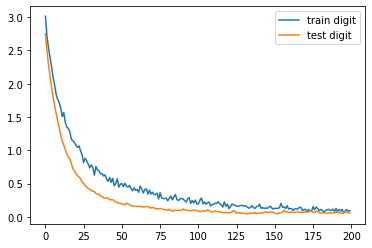

In [ ]:
# plot training history
from matplotlib import pyplot
pyplot.plot(history1.history['loss'], label='train number')
pyplot.plot(history1.history['val_loss'], label='test number')
pyplot.legend()
pyplot.show()

pyplot.plot(history2.history['loss'], label='train digit')
pyplot.plot(history2.history['val_loss'], label='test digit')
pyplot.legend()
pyplot.show()

In [ ]:
def getSpeaker(speaker):
    #speaker = str(speaker)
    if speaker == 0:
      return "Aradhita"
    if speaker == 1:
      return "Carole"
    if speaker == 2:
        return "Jackson"
    elif speaker == 3:
        return "Nicola"
    elif speaker == 4:
        return "Theo"
    else: 
        return "Unknown"
        
def printSpeakerPrediction(X_data, y_data, printDigit):
    print('\n# Generate speaker predictions')
    for i in range(len(y_data)):
        predict_x= model1.predict(X_data[i:i+1]) 
        classes_x= np.argmax(predict_x,axis=1)
        prediction = getSpeaker(classes_x[0])
        #prediction = getSpeaker(model.predict_classes(X_data[i:i+1])[0])
        speaker = getSpeaker(y_data[i])
        if printDigit == True:
            print("Number={0:d}, y={1:10s}- prediction={2:10s}- match={3}".format(i, speaker, prediction, speaker==prediction))
        else:
            print("y={0:10s}- prediction={1:10s}- match={2}".format(speaker, prediction, speaker==prediction))


def printDigitPrediction(X_data, y_data, printDigit):
    print('\n# Generate digit predictions')
    for i in range(len(y_data)):
        predict_x= model2.predict(X_data[i:i+1]) 
        classes_x= np.argmax(predict_x,axis=1)
        prediction = classes_x
        print("y={}, prediction={}, match={}".format(y_data[i], prediction, y_data[i]== (prediction[0])))           

In [ ]:
print('\n# TEST DATA for Speaker #\n')
score = model1.evaluate(X_test, y1_test)
print("%s: %.2f%%" % (model1.metrics_names[1], score[1]*100))
printSpeakerPrediction(X_test, y1_test, False)

print('\n# TEST DATA for Digit #\n')
score = model2.evaluate(X_test, y2_test)
print("%s: %.2f%%" % (model2.metrics_names[1], score[1]*100))
printDigitPrediction(X_test, y2_test, False)


# TEST DATA for Speaker #

2/2 [==============================] - 0s 7ms/step - loss: 0.0044 - accuracy: 1.0000
accuracy: 100.00%

# Generate speaker predictions
y=Nicola    - prediction=Nicola    - match=True
y=Jackson   - prediction=Jackson   - match=True
y=Theo      - prediction=Theo      - match=True
y=Theo      - prediction=Theo      - match=True
y=Nicola    - prediction=Nicola    - match=True
y=Nicola    - prediction=Nicola    - match=True
y=Theo      - prediction=Theo      - match=True
y=Jackson   - prediction=Jackson   - match=True
y=Theo      - prediction=Theo      - match=True
y=Theo      - prediction=Theo      - match=True
y=Jackson   - prediction=Jackson   - match=True
y=Theo      - prediction=Theo      - match=True
y=Theo      - prediction=Theo      - match=True
y=Nicola    - prediction=Nicola    - match=True
y=Jackson   - prediction=Jackson   - match=True
y=Jackson   - prediction=Jackson   - match=True
y=Jackson   - prediction=Jackson   - match=True
y=Nicola    - predict

In [ ]:
#https://www.youtube.com/watch?v=_FXqysbYVGs
#https://github.com/ravasconcelos/spoken-digits-recognition/blob/master/src/speaker-recognition.ipynb